## loadmnist

In [10]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [12]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

- x_train
    - 訓練用画像
    - image 28 * 28 * 50000
- y_train
    - 訓練用画像の正解データ
    - num 50000
- x_valid
    - テスト用画像
- y_valid
    - テスト用画像の正解データ

torch.Size([50000, 784])
tensor(5)
torch.Size([50000])


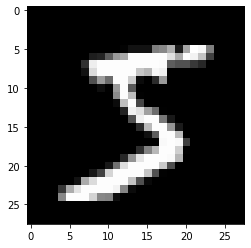

In [36]:
from matplotlib import pyplot

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

print(y_train[0])
print(y_train.shape)

convert numpy array to torch data

In [16]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/tmp/ipykernel_36304/3366171995.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


## neural net from scratch

In [17]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [19]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [21]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5175, -2.5823, -2.4091, -1.7744, -2.7814, -2.1902, -2.0663, -2.4925,
        -2.2946, -2.2999], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [22]:
def nll(input, target): # 負の対数尤度
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [24]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3340, grad_fn=<NegBackward0>)


In [28]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1719)


In [37]:
lerning_rate = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lerning_rate
            bias -= bias.grad * lerning_rate
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0602, grad_fn=<NegBackward0>) tensor(1.)


## Use torch.nn.functional

In [41]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0602, grad_fn=<NllLossBackward0>) tensor(1.)


In [43]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [45]:
model = Mnist_Logistic()
print(model.weights)
print(model.bias)

Parameter containing:
tensor([[ 0.0046, -0.0926, -0.0638,  ..., -0.0150,  0.0216, -0.0135],
        [ 0.0395,  0.0161,  0.0467,  ..., -0.0814,  0.0665,  0.0256],
        [-0.0269,  0.0080,  0.0463,  ...,  0.0661, -0.0125,  0.0295],
        ...,
        [ 0.0333,  0.0182, -0.0367,  ..., -0.0303,  0.0320,  0.0340],
        [-0.0204,  0.0598,  0.0542,  ...,  0.0295, -0.0152, -0.0252],
        [-0.0290, -0.0110, -0.0121,  ...,  0.0135, -0.0760,  0.0035]],
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [46]:
print(loss_func(model(xb), yb))

tensor(2.3645, grad_fn=<NllLossBackward0>)


In [51]:
with torch.no_grad():
    weights -= weights.grad * lerning_rate
    bias -= bias.grad * lerning_rate
    weights.grad.zero_()
    bias.grad.zero_()

In [53]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lerning_rate
                model.zero_grad()

fit()

In [54]:
print(loss_func(model(xb), yb))

tensor(0.0648, grad_fn=<NllLossBackward0>)


### use optimyzer

In [57]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lerning_rate)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad() # grad初期化

print(loss_func(model(xb), yb))

tensor(2.3834, grad_fn=<NllLossBackward0>)
tensor(0.0823, grad_fn=<NllLossBackward0>)


## use tensor dataset

In [58]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

# is equal

xb,yb = train_ds[i*bs : i*bs+bs]
```

In [61]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0775, grad_fn=<NllLossBackward0>)


## use tensor data loader

In [62]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

元データと正解データのロード
```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

# is equal

for xb,yb in train_dl:
    pred = model(xb)
```

In [63]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0828, grad_fn=<NllLossBackward0>)


## Add validatation

In [64]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [65]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3145)
1 tensor(0.2906)
